Before running code, type into terminal:
    
    python –m venv venv\ 
^this creates the virtual enviornment

    venv\Scripts\activate
^this activates the virtual environment

    python -m pip install -r requirements.txt
^this installs packages according to the requirements.txt file

In [ ]:
#Importing phydrus
import os

import phydrus as ps #this works for Meghan using version 0.2.0

import pandas as pd #this works for Meghan using version 2.3.3

import numpy as np #this works for Meghan using version 2.3.5

import matplotlib.pyplot as plt #this works for Meghan using version 3.10.7

import datetime



In [2]:
#Doing working directory stuff

#set working directory manually (I'm sure there is a better way to do this)
#os.chdir('C:\\Users\\meghanrobinson\\Downloads\\Modeling\\PHydrusTest\\PipelineStructure')

#give path to exe file
exe = os.path.join(os.getcwd(), "H1D_CALC.EXE")

#name the folder files will fill
main_level = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
newfolder = 'Test_25-12-18'
ws = os.path.join(main_level, '3_Results', newfolder)

In [3]:
#read in csvs

#Atmospheric Input
atm = pd.read_csv(os.path.join(main_level, '1_Input', 'WeatherData.csv'))
days = len(atm['Date']) #save length of days column for later steps
irrigation = pd.read_csv(os.path.join(main_level, '1_Input', 'IrrigationData.csv'))

#merge weather and irrigation and add for a total water input column
allatm = atm.join(irrigation.set_index('Date'), on='Date')
allatm['WaterIn_cm'] = allatm['Precip'] + allatm['Amount_cm']

#set potential evaporation and transpiration equal to zero by default (will edit in loop below)
allatm['PotenitalEvap'] = 0
allatm['PotentialTransp'] = 0

#add month
allatm['month'] = pd.to_datetime(allatm['Date']).dt.month

#partition ET to either all evaporation or all transpiration based on month (April-Oct all transpiration, everything else evap)
for i in range(1,len(allatm)):
    if allatm['month'][i] == 1:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]
    elif allatm['month'][i] == 2:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]
    elif allatm['month'][i] == 3:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]
    elif allatm['month'][i] == 4:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i]
    elif allatm['month'][i] == 5:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i]
    elif allatm['month'][i] == 6:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i] 
    elif allatm['month'][i] == 7:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i] 
    elif allatm['month'][i] == 8:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i] 
    elif allatm['month'][i] == 9:
        allatm['PotentialTransp'][i] = allatm['ET_cm'][i] 
    elif allatm['month'][i] == 10:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i] 
    elif allatm['month'][i] == 11:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]
    else:
        allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]

#read in roots data
#roots = pd.read_csv(os.path.join(main_level, '1_Input', 'RootData.csv'))
#allatm = allatm.join(roots.set_index('month'), on= 'month')

#create new dataframe to manipulate to be exactly what is needed for PHydrus (keeping old version w/ temperature info for now)
atm2 = allatm[['WaterIn_cm', 'PotenitalEvap', 'PotentialTransp']]

#these are required column names: 'tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT'
atm2 = atm2.rename(columns={'PotenitalEvap':'rSoil', 'WaterIn_cm':'Prec', 'PotentialTransp': 'rRoot'}) #rename columns that are there
atm2['tAtm'] = range(1,len(atm2)+1)
atm2['hCritA']= 1000000 #max allowed surface head, this is hydrus default
atm2['rB']= 0 #bottom flux, is zero for free drainage boundary condition
atm2['hB']= 0 #groundwater level, is zero if model is not being run with groundwater
atm2['hT']= 0 #surface pressure head, zero if model uses free drainage

#rearrange to match format input
atm2 = atm2[['tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT']]

#Van Genuchten parameters
vgs = pd.read_csv(os.path.join(main_level, '1_Input', 'VGParams.csv'))
vgs_1= vgs.iloc[0, 2:8] #take one row 
vgs_2= vgs.iloc[1, 2:8] #take another row 
vgs_3= vgs.iloc[2, 2:8]
vglist1= list(vgs_1)
vglist2= list(vgs_2)
vglist3= list(vgs_3)

#Observation Nodes
obs = pd.read_csv(os.path.join(main_level, '1_Input', 'ObservationInput.csv'))
obspts = obs.iloc[:, 2]
obspts= obspts*-1
obslist = list(obspts)

#Timestep list 
timesteps = [0.4] #one that intentionally doesn't work to test
timesteps2 = [0.4, 0.001, 0.003, 0.005, 0.006, 0.0001, 0.0003, 0.0004, 0.01, 0.00002,
             0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00009, 0.0002, 0.0007, 0.0009,
             0.0055, 0.0065, 0.00015, 0.00055, 0.00095] #actual good time steps

C:\Users\x63d979\AppData\Local\Temp\ipykernel_17644\1946351913.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  allatm['PotenitalEvap'][i] = allatm['ET_cm'][i]
C:\Users\x63d979\AppData\Local\Temp\ipykernel_17644\1946351913.py:22: Setting

In [4]:
allatm.iloc[548, :]

Date               2024-07-02
Precip                    0.0
ET_cm                 0.42672
MinTemp                10.675
MaxTemp                25.875
AvgTemp              17.69375
Amount_in                0.55
Amount_cm               1.397
WaterIn_cm              1.397
PotenitalEvap             0.0
PotentialTransp       0.42672
month                       7
Name: 548, dtype: object

INFO: Directory c:\Users\x63d979\Documents\HydrusCoding\Hydrus\PipelineStructure\3_Results\Test_25-12-18 created
c:\Users\x63d979\Documents\HydrusCoding\Hydrus\venv\Lib\site-packages\phydrus\model.py:492: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.    

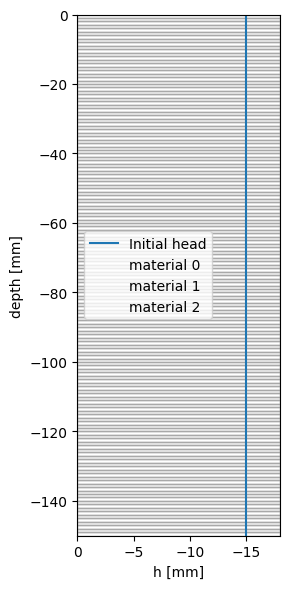

In [5]:
#Do model run

#loop iterating through time steps

for i in range(len(timesteps2)):
    #basic model info (name, units)
    ml = ps.Model(exe_name=exe, #telling it to use single porosity exe
              ws_name=ws, #folder to create/fill (in 3_Results)
              name="model",
              mass_units="mmol", time_unit="days", length_unit="mm")
    #add time info
    times = ml.add_time_info(tinit=0, #first day
                         tmax=days, #last day
                         print_times=True, #true if want model to print t level info every day
                        # printinit= 1,
                         #printmax= 40,
                         #dtprint= 1,
                         dt=timesteps2[i], #initial time increment (this is what R iteratres through)
                         dtmax=0.5, #max time increment (didn't change)
                         #printinit=120 #this would specify when to start printing t level info
                        )
    
    #add waterflow information for selector on model type, boundary conditions, can add groundwater here (didn't)
    ml.add_waterflow(model= 0, #single porosity
                 top_bc=3, #top boundary condition is atmospheric with runoff
                 bot_bc=4, #bottom boundary condition is free drainage
                 )
    
    #this is a dataframe for soil materials, n=1 is number of materials
    m = ml.get_empty_material_df(n=3)
    
    #these are vg parameters for each depth
    m.loc[1:3] = [vglist1, vglist2, vglist3]
    

    #add materials to function
    ml.add_material(m)
    
    #create soil profile
    profile = ps.create_profile(bot= -150, #depth of soil profile
                            dx= 1, #grid cells 1 cm
                            h=-15 #intial pressure head
                           )
    
    profile.loc[75:100, "Mat"] = 2 #depth to start second soil material
    profile.loc[101:150, "Mat"] = 3
        #add  profile to model
    ml.add_profile(profile)
    
    #observations nodes
    ml.add_obs_nodes(obslist)
    
    poptms= [-1,-1,-1]
    ml.add_root_uptake(model= 0, #feddes water uptake
                   p0= -1, #pressure head below which roots can extract water from soil
                   p2h= -500, #pressure head below which roots cannot extract water at maximum rate
                   p2l= -900, #manual says same as p2h exceot with potential transpiration of 'r2L'
                   p3= -1600, #wilting point: no root water extraction
                   r2h= 0.5,
                   r2l= 0.1,
                   poptm= poptms, #pressure head below which roots extract water at max rate, 1 per soil type
                   pexp= 3, #exponent for stress response function, accepting default of 3
                   crootmax= 1 #this is max concentration of solute for root uptake, this model doesn't have solutes but isn't working without
                   )
    
    #make table of root data
    '''
    rtlist = list(atm2['RootDepth'])
    rtfloat = [float(i) for i in rtlist]

    daylist = list(atm2['tAtm'])
    dayfloat = [float(i) for i in daylist]


    ml.add_root_growth(irootin= 1, #roots are a table
                       ngrowth= len(atm2), #number of data points
                       tgrowth= dayfloat, #days
                       rootdepth= rtfloat #root depths
                       )
    '''
    
    ml.add_root_growth(irootin= 2,
                       irfak= 0, #root growth is calculated from given data
                       trmin= 1, #day when roots start growing
                       trmed= 150, #time of a specific root growth benchmark
                       trmax= 365, #end of root growth period
                       xrmin= 20, #root depth at start of growth period
                       xrmed= 25, #root depth at trmed time
                       xrmax= 30, #max rooting depth
                       trperiod= 365 #number of days in root growth cycle
                       )
    
    #add atmosphere input to Hydrus
    ml.add_atmospheric_bc(atm2)
    
    #write out input files
    ml.write_input()
    
    #run Hydrus!
    rs = ml.simulate()

    #check if model ran completely
    #first step: read in output
    tlevel = ml.read_tlevel()

    #check that output length equals input length, if TRUE stop loop, if FALSE keep going
    if len(tlevel) == days:
        ml.plots.profile()
        break
    else:
        if i == len(timesteps2)-1:
            failed = pd.DataFrame()
            failed.to_csv(os.path.join(main_level, '3_Results', newfolder, 'FAILED.csv'))


c:\Users\x63d979\Documents\HydrusCoding\Hydrus\venv\Lib\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
c:\Users\x63d979\Documents\HydrusCoding\Hydrus\venv\Lib\site-packages\phydrus\read.py:219: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.drop(index=data.index[0]).apply(to_numeric,
c:\Users\x63d979\Documents\HydrusCoding\Hydrus\venv\Lib\site-packages\phydrus\read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,


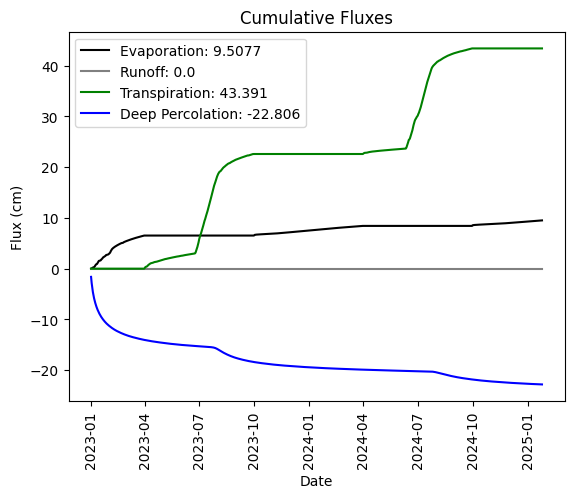

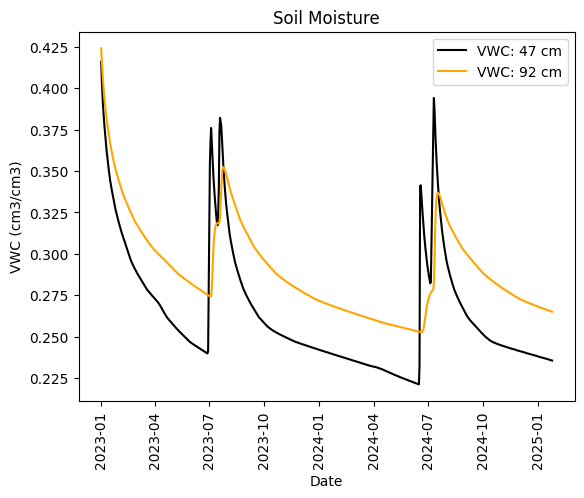

In [6]:
#Read in data and plot!
if ("FAILED.csv" in os.listdir(os.path.join(main_level, '3_Results', newfolder))) == False:
    
    #read in t level and obs node data
    tlevel = ml.read_tlevel(usecols= ['Time','rTop', 'rRoot', 'vTop', 'vRoot', 'vBot', 'sum(rTop)', 'sum(rRoot)', 'sum(vTop)',
'sum(vRoot)', 'sum(vBot)', 'hTop', 'hRoot', 'hBot', 'RunOff', 'sum(RunOff)', 'Volume', 'sum(Infil)', 'sum(Evap)', 'Cum(WTrans)'])
    obsnode = ml.read_obs_node()

    #make obs node data into a dataframe
    allobs = pd.DataFrame()
    
    for i in range(len(obslist)):
       nodenum = obslist[i]*-1+1
       obstemp =obsnode[nodenum]
       obstemp= obstemp.rename(columns={'h':f"h{nodenum}",
                             'theta':f"theta{nodenum}",
                             'Temp':f"temp{nodenum}"})
       allobs = pd.concat([allobs, obstemp], axis=1)

    #merge data to create csv file
    output = pd.concat([tlevel, allobs], axis=1)
    outputr = output.reset_index(drop=True)
    alldata = pd.concat([atm, outputr], axis= 1)


    alldata.to_csv(os.path.join(main_level, '3_Results', newfolder, 'HydrusMergedData.csv'))
    
    #make a new folder for plots to fill
    if not os.path.exists(os.path.join(main_level, '3_Results', newfolder, 'Plots')):
        os.mkdir(os.path.join(main_level, '3_Results', newfolder, 'Plots'))

    #plot cumulative fluxes
    xs= alldata['Date']
    
    from datetime import datetime
    xs = pd.to_datetime(xs)
    y1 = alldata['sum(Evap)']
    y2= alldata['sum(RunOff)']
    y3= alldata['sum(vRoot)']
    y4= alldata['sum(vBot)']
    
    #get maxes to include on plot
    emax = max(alldata['sum(Evap)'])
    tmax = max(alldata['sum(vRoot)'])
    dmax = min(alldata['sum(vBot)'])
    rmax = max(alldata['sum(RunOff)'])
    
    #plt.plot(xs, y1, xs, y2, xs, y3, xs, y4)
    plt.plot(xs, y1, label= f"Evaporation: {emax}", c= "black")
    plt.plot(xs, y2, label= f"Runoff: {rmax}", c= "gray")
    plt.plot(xs, y3, label= f"Transpiration: {tmax}", c= "green")
    plt.plot(xs, y4, label= f"Deep Percolation: {dmax}", c= "blue")
    
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Flux (cm)")
    plt.title("Cumulative Fluxes")
    plt.xticks(rotation= 90)
    
    plt.savefig(os.path.join(main_level, '3_Results', newfolder, 'Plots', 'CumulativeFluxes.png'))
    plt.show()
    #plot soil moisture at specified depths
    y1 = alldata['theta47']
    y2= alldata['theta92']
    
    plt.plot(xs, y1, label= "VWC: 47 cm", c= "black")
    plt.plot(xs, y2, label= "VWC: 92 cm", c= "orange")
    
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("VWC (cm3/cm3)")
    plt.title("Soil Moisture")
    plt.xticks(rotation= 90)

    plt.savefig(os.path.join(main_level, '3_Results', newfolder, 'Plots', 'SoilMoisture.png'))
    plt.show()
    

